# Doing a Hamiltonian Monte Carlo fit to estimate parameters 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
# Reading the data file
columns = ["x_fake", "y_fake", "error_bars_fake"]
mock_datafile = pd.read_csv("mock_data.txt", delimiter = "\t", names = columns)
x_fake = mock_datafile["x_fake"].values 
y_fake = mock_datafile["y_fake"].values
error_bars_fake = mock_datafile["error_bars_fake"].values
x_fake

array([0.27358 , 0.76267 , 1.072225, 0.871862, 1.255543, 0.383032,
       0.80475 , 0.162767, 1.306307, 1.099923, 1.33776 , 0.913578,
       0.129611, 1.150814, 0.02786 , 1.333545, 1.400884, 0.478057,
       0.119828, 1.466564, 0.67301 , 0.016418, 1.360904, 0.912002,
       0.248804, 0.305182, 0.860307, 1.154085, 0.955086, 1.053273,
       0.022836, 1.25821 , 0.848111, 1.027297, 1.10365 , 0.492057,
       0.82578 , 0.100587, 0.65786 , 1.409591, 0.31379 , 0.360869,
       1.392648, 1.370281, 0.835978, 1.220217, 0.753751, 1.400431,
       1.006834, 0.169621, 1.43627 , 1.215574, 0.092301, 0.270056,
       1.25372 , 0.608102, 0.048175, 0.599107, 0.967014, 1.462959,
       1.10017 , 0.931548, 0.964228, 0.683436, 0.874406, 0.19057 ,
       0.105616, 1.040144, 1.042258, 0.460723, 0.261688, 1.209485,
       1.469533, 0.651383, 0.359199, 1.439433, 1.453328, 0.66486 ,
       0.490275, 1.336692, 1.151068, 1.221671, 1.442536, 0.058077,
       0.398436, 0.732722, 1.298721, 1.132853, 1.123052, 0.893

In [3]:
# First define a model suitable for your data
def model_line(x,m,b):
    return m*x+b

In [4]:
# Make a function that calculates the Likelihood
# def likelihood (x,m,b,data, error):
#we want to work with logarithms
def likelihood_ls(x,m,b,data, error):
    L = -0.5* (np.sum(((data - model_line(x,m,b))/error)**2)) 
    return L

In [5]:
#initialize X_0 = (m0,b0)
m0 = 20.
b0 = -10.
p0 = likelihood_ls(x_fake,m0,b0,y_fake, error_bars_fake)
#print(p0)

Nsample = 50000
m_mcmc = []
b_mcmc = []
p_mcmc = []
#
#m[i] = m0
#b[i] = b0
#p[i] = p0
Gwidth = 0.01
m_mcmc.append(np.random.normal(m0, Gwidth ))
b_mcmc.append(np.random.normal(b0, Gwidth ))
p_mcmc.append(likelihood_ls(x_fake,m0,b0,y_fake, error_bars_fake))
for i in np.arange(Nsample):
    m_jump = np.random.normal(m_mcmc[i], Gwidth )
    b_jump = np.random.normal(b_mcmc[i], Gwidth )
    p_jump = likelihood_ls(x_fake,m_jump,b_jump,y_fake, error_bars_fake)
    p_new = p_jump - p_mcmc[i]
    #
    alpha = np.random.uniform(0.0, 1., 1)
    if alpha < np.exp(p_new):
        m_mcmc.append(m_jump)
        b_mcmc.append(b_jump)
        p_mcmc.append(p_jump)
    else:
        m_mcmc.append(m_mcmc[i])
        b_mcmc.append(b_mcmc[i])
        p_mcmc.append(p_mcmc[i])


Text(0,0.5,'b')

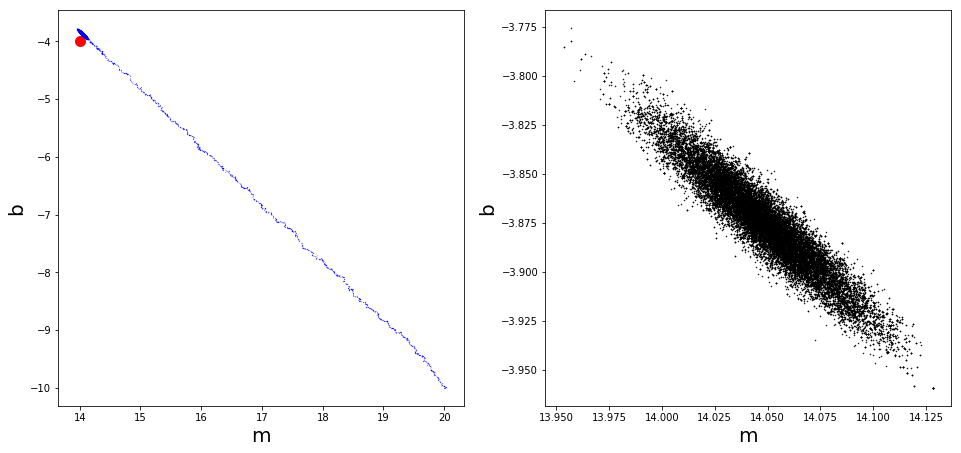

In [6]:
#Make a plot of 'm' vs "b" [What are the estimated values for those parameters?]
fig=plt.figure(figsize =(16,16))
plt.clf()
#### These are the values used to generate the mock data
m_fake = 14
b_fake = -4
####
fig.add_subplot(221)
plt.plot(m_fake, b_fake, 'ko', markersize = 10, color = 'r')
plt.plot(m_mcmc[:],b_mcmc[:],'ko', markersize = 0.08, color = 'blue')
plt.xlabel("m", size = 20)
plt.ylabel("b", size = 20)
fig.add_subplot(222)
plt.plot(m_mcmc[20000:],b_mcmc[20000:],'ko', markersize = 0.5)
#plt.plot(10, -6, 'ko', markersize = 10)
plt.xlabel("m", size = 20)
plt.ylabel("b", size = 20)




### uncertainties in the statistics


In [88]:
# Mean, standard deviation, covariance matrix

m_mean = np.mean(np.array(m_mcmc[:]))
b_mean = np.mean(np.array(b_mcmc[:]))

m_std = np.std(np.array(m_mcmc[:]))
b_std = np.std(np.array(b_mcmc[:]))

cov_matrix = np.cov(np.array(m_mcmc[:]), np.array(b_mcmc[:]))
cov_matrix

array([[ 0.52204334, -0.52338463],
       [-0.52338463,  0.52486286]])

In [89]:
print(m_mean,b_mean)

14.180649065861637 -4.00753540950387


In [90]:
cov_matrix[1][1]

0.5248628560981505

In [91]:
nume = 10000
x_fit = np.linspace(0,1.5,50)
mcmc_errors = np.zeros((nume,x_fit.size))
for i in np.arange(nume):
    mcmc_errors[i] = (np.random.normal(m_mean,np.sqrt(cov_matrix[0][0])) * x_fit +\
              np.random.normal(b_mean,np.sqrt(cov_matrix[1][1])))
    


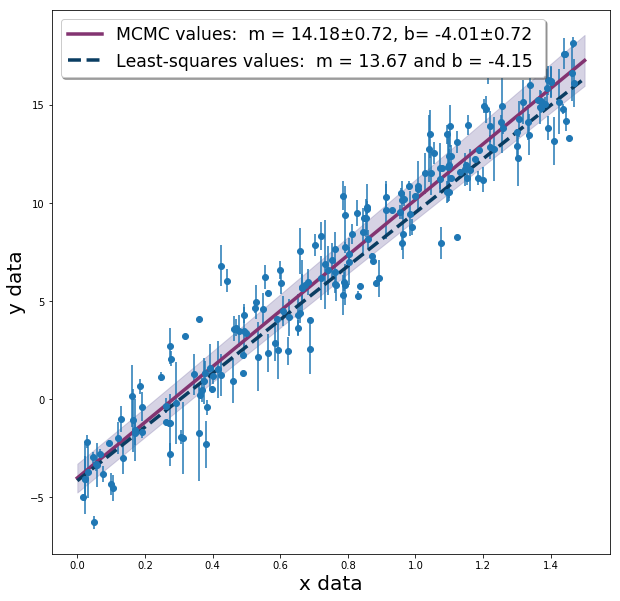

In [93]:
plt.figure(figsize=(10,10))
plt.errorbar(x_fake,y_fake, yerr = error_bars_fake, linestyle = "None", marker = "o")
x_fit = np.linspace(0,1.5, 50)
m_fit = m_mean#14.05
b_fit = b_mean#-3.87
y =model_line(x_fit, m_fit, b_fit)
plt. plot(x_fit, y, '-', linewidth = 3.5 , color = "#833471",
          label = "MCMC values:  m = {:.2f}±{:.2f}, b= {:.2f}±{:.2f}".format(m_fit,
                                                                           np.sqrt(cov_matrix[0][0]),
                                                                            b_fit,
                                                                            np.sqrt(cov_matrix[1][1])))
y_leastsqr =model_line(x_fit, 13.67, -4.15)
plt. plot(x_fit, y_leastsqr, '-', linewidth = 3.5 , 
          color = "#0a3d62", linestyle = '--',label = "Least-squares values:  m = 13.67 and b = -4.15 ")
####
plt.fill_between(x_fit,mcmc_errors.mean(axis=0)-mcmc_errors.std(axis=0),mcmc_errors.mean(axis=0)+\
                 mcmc_errors.std(axis=0),alpha=0.3,color='#786fa6')
####
plt.xlabel("x data", size = 20)
plt.ylabel("y data", size= 20)
plt.legend(loc='upper left',shadow=True, fontsize = "xx-large" )
plt.savefig("comparison_MCMC_lq.jpg")

# Estimating the cosmological parameters doing a MCMC analysis

Introduction [ taken from https://ned.ipac.caltech.edu/level5/March03/Perlmutter/frames.html  ]

**MEASURING COSMOLOGY WITH SUPERNOVAE**

Saul Perlmutter  and Brian P. Schmidt 

**Abstract.** Over the past decade, supernovae have emerged as some of the most powerful tools for measuring extragalactic distances. A well developed physical understanding of type II supernovae allow them to be used to measure distances independent of the extragalactic distance scale. Type Ia supernovae are empirical tools whose precision and intrinsic brightness make them sensitive probes of the cosmological expansion. Both types of supernovae are consistent with a Hubble Constant within $\sim$ 10% of H0 = 70 km s$^{-1}$ Mpc$^{-1}$. Two teams have used type Ia supernovae to trace the expansion of the Universe to a look-back time more than 60% of the age of the Universe. These observations show an accelerating Universe which is currently best explained by a cosmological constant or other form of dark energy with an equation of state near w = p / $\rho$ = - 1. While there are many possible remaining systematic effects, none appears large enough to challenge these current results. Future experiments are planned to better characterize the equation of state of the dark energy leading to the observed acceleration by observing hundreds or even thousands of objects. These experiments will need to carefully control systematic errors to ensure future conclusions are not dominated by effects unrelated to cosmology.



In [8]:
SNe_file_data = pd.read_csv("SN_0_pandas.txt", delimiter = "\t", header = 'infer')

In [9]:
# We want to estimate h and Omega matter
#where Mu_th is the theoretical value of the distance modulus, for which you will need to compute the
#integral for D_L numerically, using the fitting formula for a flat universe.

In [10]:
#Let's define some useful functions that are very well known in cosmology

#H0 = 100#hkm s**-1 Mpc**-1
c =2.998e5 #km/s
# 0.2 <= omega_m <= 1.0
#OmegaM = np.arange(0.2, 1.0, 0.1)

def H0(h):
    return 100*h #kms**-1Mpc**-1
    

def func_s_cube(OmegaM):
    return (1.0-OmegaM)/OmegaM
    #return s3**(1./3.)

def func_eta(a,OmegaM):
    term1 = np.sqrt(func_s_cube(OmegaM) + 1)
    term2 = 1./(a**4.)
    term3 = (func_s_cube(OmegaM)**(1./3.))/(a**3.)
    term4 = (func_s_cube(OmegaM)**(2./3.))/(a**2.)
    term5 = func_s_cube(OmegaM)/a
    term6 = func_s_cube(OmegaM)**(4./3.)
    eta_i = 2.* term1*(( term2 -0.1540*term3 + 0.4303*term4 + 0.19097*term5 + 0.066941*term6 )**(-1./8.))
    return eta_i

def func_DL(h,redshift,OmegaM):
    a1 = 1.
    a2 = 1./(1.0+redshift)
    term1 = c/H0(h)
    term2 = (1+redshift)
    luminosity_dist = term1*term2*(func_eta(a1,OmegaM)- func_eta(a2,OmegaM))
    return luminosity_dist

    

In [11]:
# Testing
h = 0.63
redshift = 1.0
OmegaM = 0.3

a= 1
func_DL(h,redshift,OmegaM)

7347.9610898245

In [12]:
### #1. Define the model

def mu_model(h,redshift, OmegaM):
    return 25. - (5.*np.log10(h)) + 5.*np.log10(func_DL(h,redshift,OmegaM))

#2. Make a Likelihood function
def likelihood(h,redshift, OmegaM, mu_data, error):
    return -(1/2)*np.sum(   (mu_model(h,redshift, OmegaM)- mu_data)**2./(error**2.)         )

In [13]:
# 1. initialize 
redshift = SNe_file_data['  z'] #we take the values from the data file but this can also be an arange
mu_data = SNe_file_data['  mu']
error = SNe_file_data['sigma']

#initial_h, initial_Omega_m = [1.,0.2] 
initial_h = 3.5
initial_Omega_m = 1.2
# loop in the samples
Nsample = 50000
sd = 0.02
h_mcmc = []
Omega_m_mcmc = []
likelihood_mcmc = []

h_mcmc.append(np.random.normal(initial_h, sd))
Omega_m_mcmc.append(np.random.normal(initial_Omega_m, sd))
likelihood_mcmc.append(likelihood(initial_h, redshift, initial_Omega_m, mu_data, error))
for i in np.arange(Nsample):
# generate a distribution in each of the initial values
    h_normal_jump = np.random.normal(h_mcmc[i], sd)
    Omega_m_normal_jump = np.random.normal(Omega_m_mcmc[i], sd)
    likelihood_jump = likelihood(h_normal_jump, redshift, Omega_m_normal_jump, mu_data, error)
    #print(likelihood_jump)
    limcmc_new = likelihood_jump - likelihood_mcmc[i]
    #
    alpha = np.random.uniform(0.0, 1., 1)
    #print(alpha,limcmc_new)
    if alpha < np.exp(limcmc_new):
        h_mcmc.append(h_normal_jump)
        Omega_m_mcmc.append(Omega_m_normal_jump)
        likelihood_mcmc.append(likelihood_jump)
    else:
        h_mcmc.append(h_mcmc[i])
        Omega_m_mcmc.append(Omega_m_mcmc[i])
        likelihood_mcmc.append(likelihood_mcmc[i])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp


Text(0,0.5,'$\\Omega_m$')

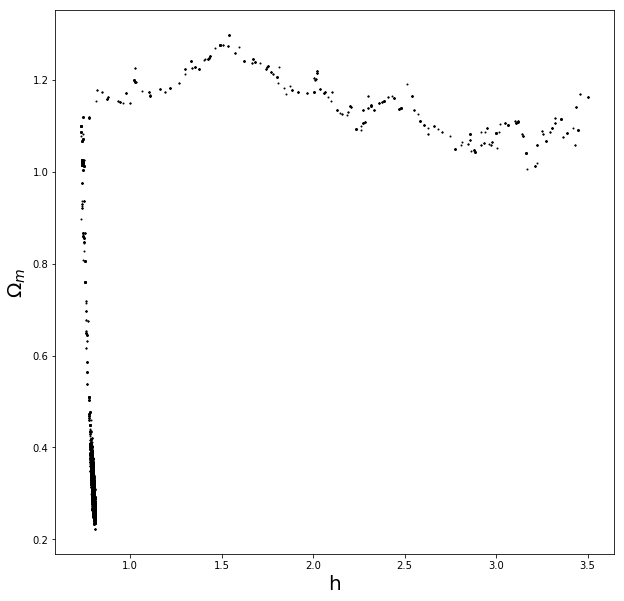

In [14]:
plt.figure(figsize=(10,10))
plt.plot(h_mcmc[:],Omega_m_mcmc[:],'ko', marker = 'o', markersize =1 )
plt.xlabel('h', size = 20)
plt.ylabel('$\Omega_m$', size = 20)

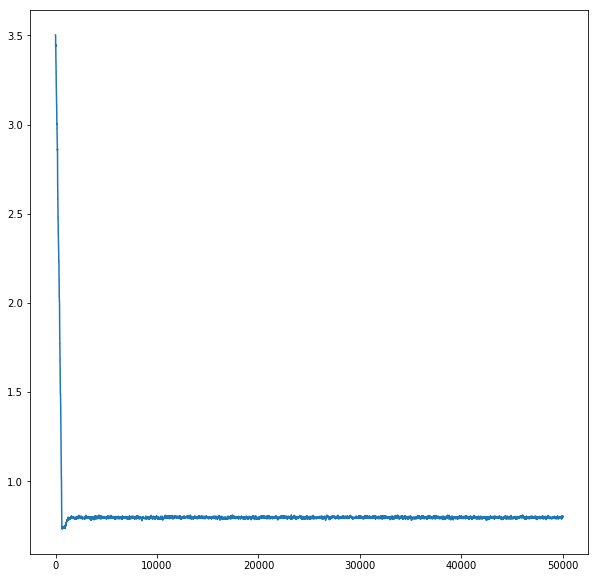

In [15]:
# By doing this plot we can see the **burning* 
# So we take some redundant points 
plt.figure(figsize=(10,10))
plt.plot(h_mcmc[:])

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'h')

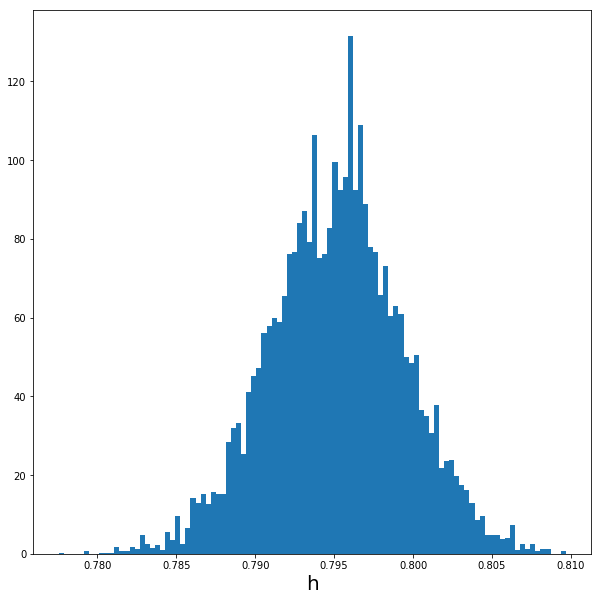

In [16]:
plt.figure(figsize=(10,10))
plt.hist(h_mcmc[2000:],bins=100,normed=True,orientation='vertical')
plt.xlabel("h", size = 20)

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


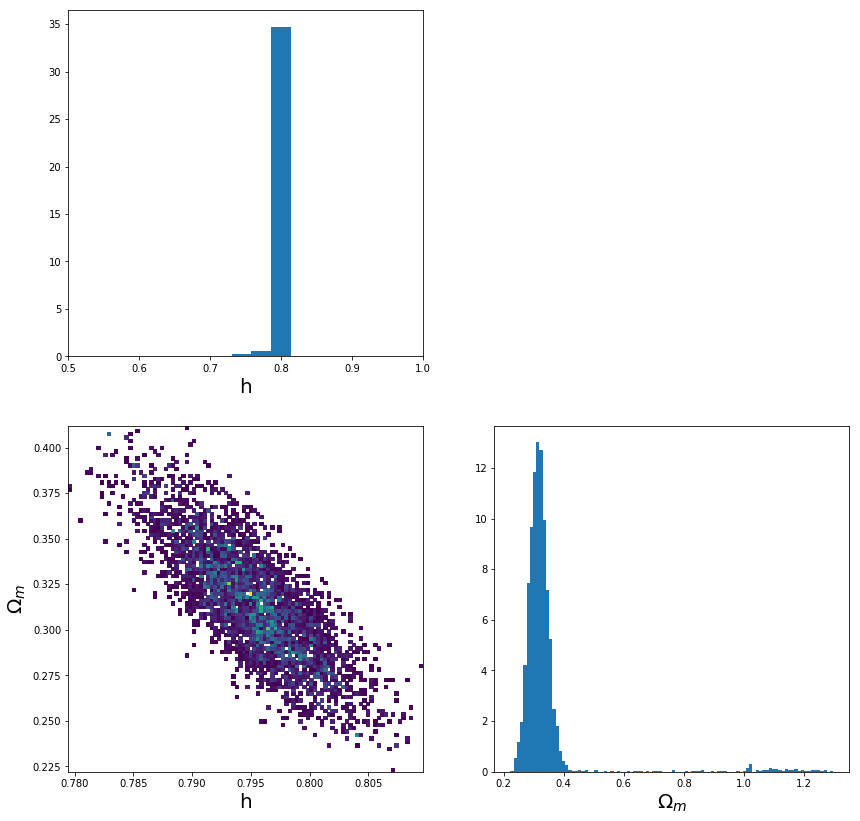

In [17]:
fig=plt.figure(figsize =(14,14))
plt.clf()
fig.add_subplot(221)
plt.hist(h_mcmc[:],bins=100,normed=True,orientation='vertical')#,weights=n.ones(Ns)*0.25)
plt.xlabel("h", size =20)
plt.xlim(0.5,1.0)
fig.add_subplot(224)
plt.hist(Omega_m_mcmc[:],bins=100,normed=True)#,weights=n.ones(Ns)*0.25)
plt.xlabel("$\Omega_m$", size = 20)
fig.add_subplot(223)
#plt.scatter(Hs,Omegas)
nbins = 100
H, xedges, yedges = np.histogram2d(h_mcmc[20000:],Omega_m_mcmc[20000:],bins=nbins)
H = np.rot90(H)
H = np.flipud(H)
plt.xlabel("h", size =20)
plt.ylabel("$\Omega_m$", size = 20)
Hmasked = np.ma.masked_where(H==0,H)
plt.pcolormesh(xedges,yedges,Hmasked/Hmasked.max())
plt.savefig("corner_plot_MCMC.jpg")

# Using the estimated values to fit the real data

Text(0,0.5,'$\\mu$')

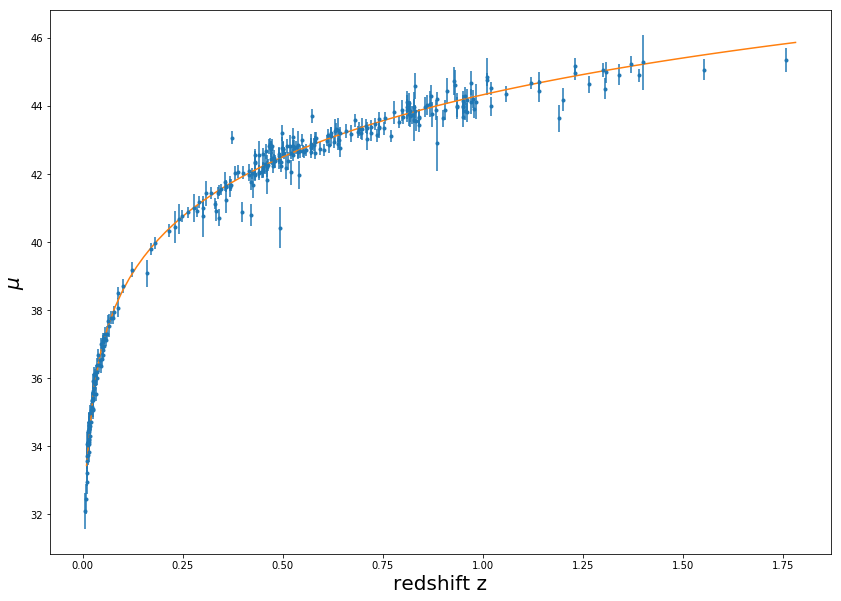

In [18]:
plt.figure(figsize=(14,10))
#From MCMC [plot above]
h_mcmc = 0.79
Omega_m_mcmc = 0.315
plt.errorbar(SNe_file_data['  z'], SNe_file_data['  mu'], yerr=SNe_file_data['sigma'], xerr=None, marker = '.' , linestyle = 'None')
x_dummy = np.linspace(0.01,1.78,100)
plt.plot(x_dummy, mu_model(h_mcmc,x_dummy,Omega_m_mcmc))
plt.xlabel('redshift z', size = 20)
plt.ylabel(r'$\mu$', size = 20)